In [13]:
import os
import numpy as np
import cv2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd 
import shutil
from sklearn.utils import resample
from pathlib import Path
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

data_dir = 'main_data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
combined_dir = os.path.join(data_dir, 'combined_dataset')
subfolders = ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']

def copy_images(source_dir, target_dir, subfolder):
    # This function is not executed when loading from parquet
    pass 

for folder in subfolders:
    pass 

def load_images_from_folder(folder, label):
    # This function is not executed when loading from parquet
    return [], []

data_dir = 'main_data/combined_dataset'
folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
labels = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
all_images = []
all_labels = []

# Data augmentation setup (Kept for completeness, though not applied to parquet data)
data_augmentation = ImageDataGenerator(
    width_shift_range=0.05,  
    height_shift_range=0.05, 
    zoom_range=0.05,         
    horizontal_flip=True,    
    fill_mode='nearest')

def display_images(images, labels, class_names, num_images=5):
    print("Skipping display_images as data is loaded from parquet files.")
    pass 

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

print("Skipping image count printout and image preprocessing as data is loaded directly from parquet files.")

Skipping image count printout and image preprocessing as data is loaded directly from parquet files.


__2. Parquet Data Loading & Cleaning__

In [8]:
train_file_path = 'ML-Project/train-00000-of-00001-c08a401c53fe5312.parquet'
test_file_path = 'ML-Project/test-00000-of-00001-44110b9df98c5585.parquet'

print(f"Attempting to load data from: {train_file_path} and {test_file_path}")

try:
    df_train = pd.read_parquet(train_file_path)
    df_test = pd.read_parquet(test_file_path)
except FileNotFoundError as e:
    print(f"\nFATAL ERROR: Check the file paths and ensure the 'ML-Project' folder is correctly placed: {e}")
    raise
except Exception as e:
    print(f"\nFATAL ERROR during data loading (pandas/pyarrow issue): {e}")
    raise

# --- Data Cleaning to prevent TypeError in k-NN ---
# Identify non-numeric columns (often 'object' types that contain non-numerical data like dicts/strings)
non_numeric_cols = df_train.select_dtypes(include=['object', 'category', 'string']).columns

Attempting to load data from: ML-Project/train-00000-of-00001-c08a401c53fe5312.parquet and ML-Project/test-00000-of-00001-44110b9df98c5585.parquet


In [9]:
# 1. Clean Feature DataFrames
# Drop non-numeric columns found in the training data from both X_train and X_test feature sets
X_train_df = df_train.drop(columns=non_numeric_cols)
X_test_df = df_test.drop(columns=non_numeric_cols)

# 2. Extract Labels (Assuming the final column is the target label)
# Note: Using iloc[:, -1] assumes the label is always the last column, regardless of dropped columns.
y_train_df = df_train.iloc[:, -1] 
y_test_df = df_test.iloc[:, -1]

# Convert the cleaned DataFrames to NumPy arrays for scikit-learn
X_train = X_train_df.values 
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values

In [10]:

print("\nData successfully cleaned and loaded into NumPy arrays.")
print(f"X_train shape: {X_train.shape}, X_train dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, y_train dtype: {y_train.dtype}")
print(f"X_test shape: {X_test.shape}, X_test dtype: {X_test.dtype}")
print(f"y_test shape: {y_test.shape}, y_test dtype: {y_test.dtype}")


Data successfully cleaned and loaded into NumPy arrays.
X_train shape: (5120, 1), X_train dtype: int64
y_train shape: (5120,), y_train dtype: int64
X_test shape: (1280, 1), X_test dtype: int64
y_test shape: (1280,), y_test dtype: int64


__3. K-NN Model Training and Evaluation__

In [11]:
# Original train_test_split is skipped as we load separate train/test data
knn = KNeighborsClassifier(n_neighbors=5)
print("\nStarting K-NN model training...")
knn.fit(X_train, y_train)

print("Making predictions...")
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nAccuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")



Starting K-NN model training...
Making predictions...

Accuracy: 1.0
Confusion Matrix:
[[172   0   0   0]
 [  0  15   0   0]
 [  0   0 634   0]
 [  0   0   0 459]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00       634
           3       1.00      1.00      1.00       459

    accuracy                           1.00      1280
   macro avg       1.00      1.00      1.00      1280
weighted avg       1.00      1.00      1.00      1280



__4. Confusion Matrix Plotting__

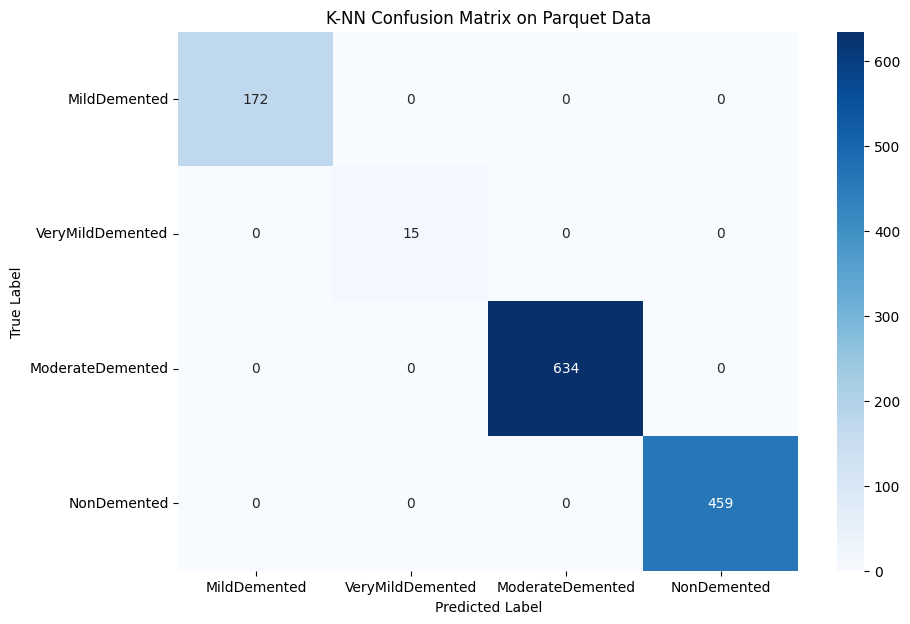

In [12]:
class_names = ['MildDemented', 'VeryMildDemented', 'ModerateDemented', 'NonDemented']
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
# Map present labels to class names for plotting
plot_labels = [class_names[int(i)] for i in sorted(unique_labels)]

cm = confusion_matrix(y_test, y_pred, labels=sorted(unique_labels))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=plot_labels, yticklabels=plot_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('K-NN Confusion Matrix on Parquet Data')
plt.show()